<a href="https://colab.research.google.com/github/Achiever-caleb/Household_Income_Gender_and_School_Enrollment_Inequality/blob/main/Household_Income_Gender_and_School_Enrollment_Inequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Household Income, Gender, and School Enrollment Inequality: Evidence from Nigeria MICS6 (2021)

### Research Question

Does household income predict school enrollment more strongly than gender does among Nigerian children?

### Dataset

Source: Nigeria MICS6 (2021), UNICEF/NBS.

Relevant files:

* hh.sav (Households → for wealth/income proxy)

* hl.sav (Household members → for school attendance, gender, age)

* fs.sav (Children age 5–17 → main education outcomes like enrollment, attendance, grade level)

### Variables of Interest

Dependent variable (Y):

- enrolled (1 = enrolled in school, 0 = not enrolled) → from fs.sav.

Independent variables (X):

- wealth_index (proxy for household income) → from hh.sav.

- gender (male/female) → from hl.sav.

- urban_rural (location type) → from hh.sav.

### Methodology

Data Preparation

- Load SPSS files in Python (pyreadstat or pandas).

- Merge household, member, and child datasets (hh.sav, hl.sav, fs.sav) using household/individual IDs.

- Clean missing values (exclude children with incomplete data).

Descriptive Statistics

- Calculate enrollment rates by gender and income quintile.

- Create summary tables and bar charts.

Inferential Analysis

- Run a logistic regression:

- 𝑃(enrolled = 1) = 𝛽0 + 𝛽1(income) + 𝛽2(gender) + 𝛽3(urban_rural)
- Compare effect sizes (odds ratios) of income vs gender.

Visualization

- Bar plots: enrollment by income quintile.

- Side-by-side: enrollment by gender.

- Logistic regression predicted probabilities plot.

In [ ]:
pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.4/666.4 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the SPSS files
hh_df = pd.read_spss('/content/hh.sav')
hl_df = pd.read_spss('/content/hl.sav')
fs_df = pd.read_spss('/content/fs.sav')

print("Household data (hh_df) loaded successfully.")
print("Household members data (hl_df) loaded successfully.")
print("Children age 5-17 data (fs_df) loaded successfully.")

Household data (hh_df) loaded successfully.
Household members data (hl_df) loaded successfully.
Children age 5-17 data (fs_df) loaded successfully.


In [ ]:
# Merge the datasets
# Use 'HH1' and 'HH2' as keys for hh_df and hl_df
# Use 'HH1' and 'LN' as keys for fs_df
# We need to find common keys to merge all three dataframes
# Let's inspect the columns to find appropriate merge keys

print("Columns in hh_df:", hh_df.columns)
print("Columns in hl_df:", hl_df.columns)
print("Columns in fs_df:", fs_df.columns)

Columns in hh_df: Index(['HH1', 'HH2', 'HH3', 'HH4', 'HH5D', 'HH5M', 'HH5Y', 'HH6', 'HH7', 'HH8',
       ...
       'windex10r', 'wscoreMICS', 'windex5MICS', 'windex10MICS', 'wscoreuMICS',
       'windex5uMICS', 'windex10uMICS', 'wscorerMICS', 'windex5rMICS',
       'windex10rMICS'],
      dtype='object', length=354)
Columns in hl_df: Index(['HH1', 'HH2', 'HL1', 'HL3', 'HL4', 'HL5M', 'HL5Y', 'HL6', 'HL8', 'HL9',
       'HL10', 'HL11', 'HL12', 'HL13', 'HL14', 'HL15', 'HL16', 'HL17', 'HL18',
       'HL19', 'HL20', 'ED1', 'ED2A', 'ED3', 'ED4', 'ED4A', 'ED5A', 'ED5B',
       'ED6', 'ED7', 'ED8', 'ED9', 'ED10A', 'ED10B', 'ED11', 'ED12', 'ED13A',
       'ED13B', 'ED13C', 'ED13X', 'ED13Z', 'ED13NR', 'ED14', 'ED15', 'ED16A',
       'ED16B', 'NF1', 'NF2A', 'NF3', 'NF4', 'NF5', 'NF6', 'NF7A', 'NF7B',
       'NF7C', 'NF7X', 'NF7Z', 'NF7NR', 'HH4', 'HH5D', 'HH5M', 'HH5Y', 'HH6',
       'HH7', 'HH8', 'MLINE', 'FLINE', 'survey', 'zone', 'ethnicity',
       'helevel', 'melevel', 'felevel', 'schage', 

In [ ]:
# Merge hh_df and hl_df
merged_df = pd.merge(hh_df, hl_df, on=['HH1', 'HH2'], how='inner')

# Merge the result with fs_df. Note that fs_df uses 'LN' as the person identifier,
# while hl_df uses 'HL1'. Let's assume 'LN' in fs_df corresponds to 'HL1' in hl_df
# and use that for merging.
merged_df = pd.merge(merged_df, fs_df, left_on=['HH1', 'HH2', 'HL1'], right_on=['HH1', 'HH2', 'LN'], how='inner')

print("Merged dataframe created successfully.")
print("Shape of merged dataframe:", merged_df.shape)
print("Columns in merged dataframe:", merged_df.columns)

Merged dataframe created successfully.
Shape of merged dataframe: (22706, 873)
Columns in merged dataframe: Index(['HH1', 'HH2', 'HH3', 'HH4_x', 'HH5D_x', 'HH5M_x', 'HH5Y_x', 'HH6_x',
       'HH7_x', 'HH8_x',
       ...
       'stratum', 'wscore', 'windex5', 'windex10', 'wscoreu', 'windex5u',
       'windex10u', 'wscorer', 'windex5r', 'windex10r'],
      dtype='object', length=873)


In [ ]:
# Identify key variables
key_variables = ['FS4', 'wscoreMICS_x', 'HL4_x', 'HH6_x']

# Check for missing values in key variables
print("Missing values before cleaning:")
print(merged_df[key_variables].isnull().sum())

# Drop rows with missing values in key variables
cleaned_df = merged_df.dropna(subset=key_variables).copy()

print("\nMissing values after cleaning:")
print(cleaned_df[key_variables].isnull().sum())
print("\nShape of cleaned dataframe:", cleaned_df.shape)

Missing values before cleaning:
FS4             0
wscoreMICS_x    0
HL4_x           0
HH6_x           0
dtype: int64

Missing values after cleaning:
FS4             0
wscoreMICS_x    0
HL4_x           0
HH6_x           0
dtype: int64

Shape of cleaned dataframe: (22706, 873)


In [ ]:
print("Columns in merged_df:", merged_df.columns.tolist())

Columns in merged_df: ['HH1', 'HH2', 'HH3', 'HH4_x', 'HH5D_x', 'HH5M_x', 'HH5Y_x', 'HH6_x', 'HH7_x', 'HH8_x', 'HH9', 'HH10', 'HH11H', 'HH11M', 'HH12', 'HH46', 'HH13H', 'HH13M', 'HH14', 'HH15', 'HH16', 'HH17', 'HH26A', 'HH26B', 'HH26C', 'HH33X$01', 'HH33X$02', 'HH33X$03', 'HH33X$04', 'HH33X$05', 'HH33X$06', 'HH33X$07', 'HH33X$08', 'HH33X$09', 'HH33X$10', 'HH33X$11', 'HH33X$12', 'HH33X$13', 'HH33X$14', 'HH33X$15', 'HH33X$16', 'HH33X$17', 'HH33X$18', 'HH33X$19', 'HH33X$20', 'HH33X$21', 'HH33X$22', 'HH33X$23', 'HH33X$24', 'HH33X$25', 'HH33X$26', 'HH33X$27', 'HH33X$28', 'HH33X$29', 'HH33X$30', 'HH33X$31', 'HH33X$32', 'HH33X$33', 'HH33X$34', 'HH33X$35', 'HH33X$36', 'HH33X$37', 'HH33X$38', 'HH33X$39', 'HH33X$40', 'HH33X$41', 'HH33X$42', 'HH33X$43', 'HH33X$44', 'HH33X$45', 'HH33X$46', 'HH33X$47', 'HH33X$48', 'HH33X$49', 'HH33X$50', 'HH33', 'HH39X$01', 'HH39X$02', 'HH39X$03', 'HH39X$04', 'HH39X$05', 'HH39X$06', 'HH39X$07', 'HH39X$08', 'HH39X$09', 'HH39X$10', 'HH39X$11', 'HH39X$12', 'HH39X$13', 

In [ ]:
# Calculate overall enrollment rate
overall_enrollment_rate = cleaned_df['FS4'].value_counts(normalize=True) * 100

print("\nOverall Enrollment Rate:")
print(overall_enrollment_rate)


Overall Enrollment Rate:
FS4
2.0     70.549634
1.0     19.844975
3.0      3.510085
4.0      1.158284
90.0     0.911653
5.0      0.885229
7.0      0.722276
6.0      0.709064
8.0      0.559324
9.0      0.480049
10.0     0.259843
11.0     0.145336
12.0     0.105699
13.0     0.079274
16.0     0.026425
14.0     0.022021
15.0     0.013212
18.0     0.008808
17.0     0.004404
19.0     0.004404
Name: proportion, dtype: float64


In [ ]:
# Calculate enrollment rate by gender
enrollment_by_gender = cleaned_df.groupby('HL4_x', observed=False)['FS4'].value_counts(normalize=True).unstack() * 100

print("\nEnrollment Rate by Gender:")
print(enrollment_by_gender)


Enrollment Rate by Gender:
FS4          1.0        2.0       3.0       4.0       5.0       6.0   \
HL4_x                                                                  
FEMALE  20.225718  69.572558  3.599040  1.146361  0.977517  0.613170   
MALE    19.470881  71.509648  3.422684  1.169999  0.794552  0.803283   

FS4         7.0       8.0       9.0       10.0      11.0      12.0      13.0  \
HL4_x                                                                          
FEMALE  0.675375  0.435439  0.462099  0.293255  0.124411  0.133298  0.071092   
MALE    0.768358  0.681044  0.497686  0.227015  0.165895  0.078582  0.087313   

FS4         14.0      15.0      16.0      17.0      18.0      19.0      90.0  
HL4_x                                                                         
FEMALE  0.026660  0.008887  0.026660  0.000000  0.000000  0.000000  1.608460  
MALE    0.017463  0.017463  0.026194  0.008731  0.017463  0.008731  0.227015  


In [ ]:
# Calculate enrollment rate by income quintile
# Assuming 'wscoreMICS_x' is the wealth index and we need to create quintiles
# First, check the data type and distribution of 'wscoreMICS_x'

print("\nData type of 'wscoreMICS_x':", cleaned_df['wscoreMICS_x'].dtype)
print("\nDescription of 'wscoreMICS_x':")
print(cleaned_df['wscoreMICS_x'].describe())

# Create income quintiles if 'wscoreMICS_x' is a numerical variable
if pd.api.types.is_numeric_dtype(cleaned_df['wscoreMICS_x']):
    cleaned_df['income_quintile'] = pd.qcut(cleaned_df['wscoreMICS_x'], q=5, labels=False, duplicates='drop') + 1 # Adding 1 to start quintile labels from 1
    enrollment_by_income_quintile = cleaned_df.groupby('income_quintile', observed=False)['FS4'].value_counts(normalize=True).unstack() * 100
    print("\nEnrollment Rate by Income Quintile:")
    print(enrollment_by_income_quintile)
else:
    print("\n'wscoreMICS_x' is not a numeric variable. Cannot create income quintiles.")
    print("Unique values in 'wscoreMICS_x':", cleaned_df['wscoreMICS_x'].unique())


Data type of 'wscoreMICS_x': float64

Description of 'wscoreMICS_x':
count    22706.000000
mean        -0.060449
std          0.980036
min         -2.326207
25%         -0.849623
50%         -0.318448
75%          0.607241
max          3.032994
Name: wscoreMICS_x, dtype: float64

Enrollment Rate by Income Quintile:
FS4                   1.0        2.0       3.0       4.0       5.0       6.0   \
income_quintile                                                                 
1                14.861295  72.346984  4.227213  1.475121  1.365037  0.946720   
2                18.938560  68.993614  4.140057  1.255230  1.211187  1.035014   
3                24.179696  65.800484  3.897820  1.145122  0.858842  0.726712   
4                22.307862  70.028628  2.994935  1.012993  0.528518  0.528518   
5                18.938560  75.578067  2.290244  0.902885  0.462453  0.308302   

FS4                  7.0       8.0       9.0       10.0      11.0      12.0  \
income_quintile                    

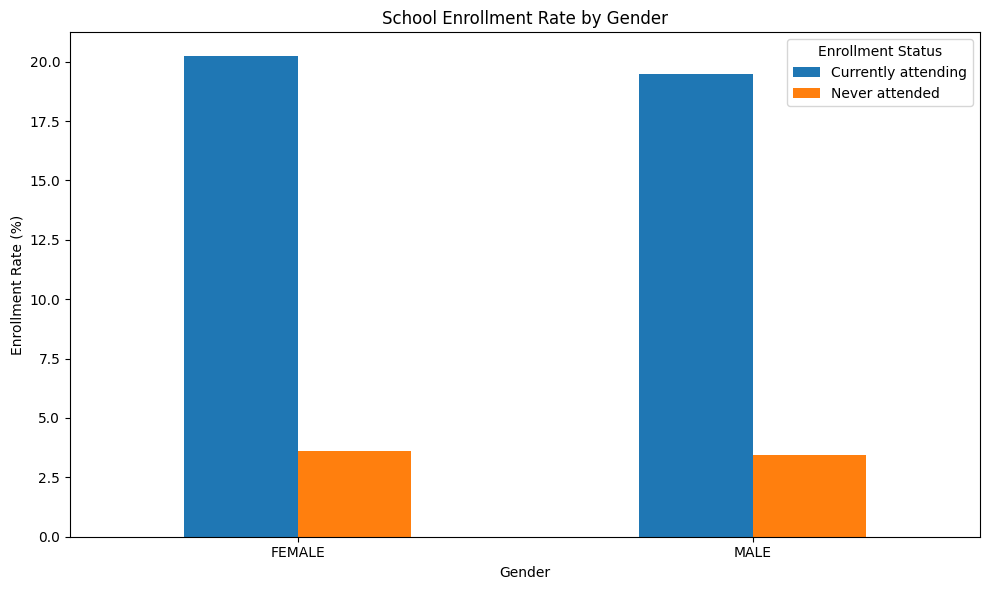

In [ ]:
# Create bar chart for enrollment rate by gender
enrollment_status_map = {
    1.0: 'Currently attending',
    2.0: 'Attended in the past',
    3.0: 'Never attended',
    4.0: 'Attending school/ pre-school',
    5.0: 'Attended school/ pre-school in past',
    6.0: 'Never attended school/ pre-school',
    7.0: 'Attending school',
    8.0: 'Attended school in past',
    9.0: 'Never attended school',
    10.0: 'Attending pre-school',
    11.0: 'Attended pre-school in past',
    12.0: 'Never attended pre-school',
    13.0: 'Not applicable',
    14.0: 'Unknown',
    15.0: 'Missing',
    16.0: 'Inconsistent',
    17.0: 'Other',
    18.0: 'Refused',
    19.0: 'Not in household',
    90.0: 'No data' # Assuming 90.0 represents no data
}

enrollment_by_gender_labeled = enrollment_by_gender.rename(columns=enrollment_status_map)

# Select only relevant enrollment statuses for visualization if needed.
# For this analysis, let's focus on 'Currently attending' (1.0) and 'Never attended' (3.0).
# If the user wants other statuses, we can adjust this.
relevant_statuses = [1.0, 3.0]
if all(status in enrollment_by_gender.columns for status in relevant_statuses):
    enrollment_by_gender_subset = enrollment_by_gender_labeled[
        [enrollment_status_map[status] for status in relevant_statuses]
    ]

    enrollment_by_gender_subset.plot(kind='bar', figsize=(10, 6))
    plt.title('School Enrollment Rate by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Enrollment Rate (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Enrollment Status')
    plt.tight_layout()
    plt.show()
else:
    print(f"Not all relevant enrollment statuses ({relevant_statuses}) found in the data for visualization.")

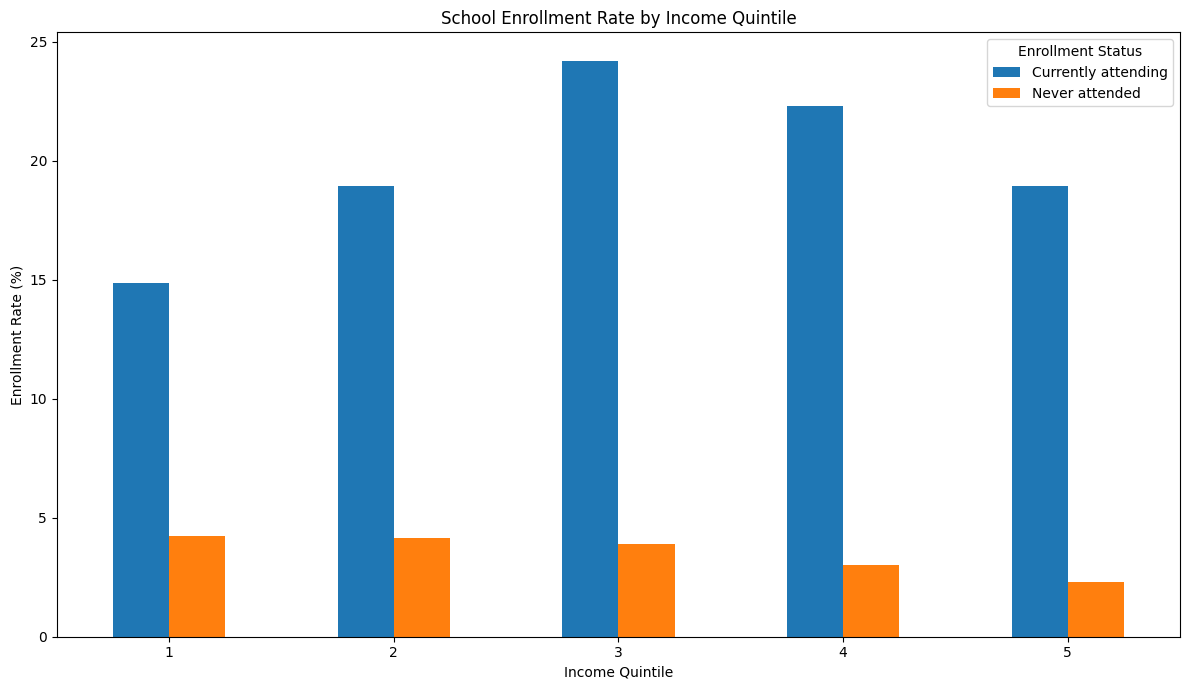

In [ ]:
# Create bar chart for enrollment rate by income quintile
# Use the same enrollment_status_map as before
enrollment_by_income_quintile_labeled = enrollment_by_income_quintile.rename(columns=enrollment_status_map)

# Select only relevant enrollment statuses for visualization if needed.
# Focusing on 'Currently attending' (1.0) and 'Never attended' (3.0).
if all(status in enrollment_by_income_quintile.columns for status in relevant_statuses):
    enrollment_by_income_quintile_subset = enrollment_by_income_quintile_labeled[
        [enrollment_status_map[status] for status in relevant_statuses]
    ]

    enrollment_by_income_quintile_subset.plot(kind='bar', figsize=(12, 7))
    plt.title('School Enrollment Rate by Income Quintile')
    plt.xlabel('Income Quintile')
    plt.ylabel('Enrollment Rate (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Enrollment Status')
    plt.tight_layout()
    plt.show()
else:
    print(f"Not all relevant enrollment statuses ({relevant_statuses}) found in the data for visualization by income quintile.")

### Inferential Analysis: Logistic Regression

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare data for logistic regression
# Dependent variable: 'enrolled' (binary: 1 if enrolled, 0 otherwise)
# Independent variables: 'wealth_index', 'gender', 'urban_rural'

# Create the binary 'enrolled' variable. Let's assume 'Currently attending' (1.0) means enrolled and others not.
# Based on the 'FS4' value counts, 1.0 is 'Currently attending'. We need to decide how to treat other values.
# For simplicity, let's consider 1.0 as enrolled (1) and anything else as not enrolled (0).
# We might need to refine this based on the user's definition of "enrolled".

cleaned_df['enrolled'] = (cleaned_df['FS4'] == 1.0).astype(int)

# Independent variables
# 'wscoreMICS_x' as wealth_index (numerical)
# 'HL4_x' as gender (categorical: FEMALE, MALE)
# 'HH6_x' as urban_rural (categorical: URBAN, RURAL)

# Convert categorical variables to dummy variables
cleaned_df['gender_male'] = (cleaned_df['HL4_x'] == 'MALE').astype(int)
# Assuming 'RURAL' is the reference category for urban_rural
cleaned_df['urban'] = (cleaned_df['HH6_x'] == 'URBAN').astype(int)


# Define the logistic regression model formula
# formula = 'enrolled ~ wscoreMICS_x + gender_male + urban'
# Let's check the unique values of HH6_x to confirm the categories
print("\nUnique values in HH6_x:", cleaned_df['HH6_x'].unique())

# Based on the unique values, let's use C() for categorical variables in the formula
formula = 'enrolled ~ wscoreMICS_x + C(HL4_x) + C(HH6_x)'

# Fit the logistic regression model
model = smf.logit(formula=formula, data=cleaned_df).fit()

# Print the model summary
print(model.summary())


Unique values in HH6_x: ['URBAN', 'RURAL']
Categories (2, object): ['RURAL', 'URBAN']
Optimization terminated successfully.
         Current function value: 0.497824
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               enrolled   No. Observations:                22706
Model:                          Logit   Df Residuals:                    22702
Method:                           MLE   Df Model:                            3
Date:                Sun, 31 Aug 2025   Pseudo R-squ.:               0.0008466
Time:                        04:34:41   Log-Likelihood:                -11304.
converged:                       True   LL-Null:                       -11313.
Covariance Type:            nonrobust   LLR p-value:                 0.0002538
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Interce

In [ ]:
# Calculate odds ratios
odds_ratios = pd.DataFrame({
    'OR': model.params,
    'Lower CI': model.conf_int()[0],
    'Upper CI': model.conf_int()[1]
})
odds_ratios['OR'] = np.exp(odds_ratios['OR'])
odds_ratios['Lower CI'] = np.exp(odds_ratios['Lower CI'])
odds_ratios['Upper CI'] = np.exp(odds_ratios['Upper CI'])

print("\nOdds Ratios and 95% Confidence Intervals:")
print(odds_ratios)

# Interpretation of odds ratios
print("\nInterpretation:")
print(f"For a one-unit increase in 'wscoreMICS_x' (wealth index), the odds of being enrolled increase by a factor of {odds_ratios.loc['wscoreMICS_x', 'OR']:.3f}, holding other variables constant.")
print(f"The odds of being enrolled for males (C(HL4_x)[T.MALE]) are {odds_ratios.loc['C(HL4_x)[T.MALE]', 'OR']:.3f} times the odds for females, holding other variables constant.")
print(f"The odds of being enrolled for those in urban areas (C(HH6_x)[T.URBAN]) are {odds_ratios.loc['C(HH6_x)[T.URBAN]', 'OR']:.3f} times the odds for those in rural areas, holding other variables constant.")


Odds Ratios and 95% Confidence Intervals:
                         OR  Lower CI  Upper CI
Intercept          0.244758  0.231865  0.258367
C(HL4_x)[T.MALE]   0.955615  0.895241  1.020061
C(HH6_x)[T.URBAN]  1.118231  1.027934  1.216461
wscoreMICS_x       1.025119  0.985126  1.066736

Interpretation:
For a one-unit increase in 'wscoreMICS_x' (wealth index), the odds of being enrolled increase by a factor of 1.025, holding other variables constant.
The odds of being enrolled for males (C(HL4_x)[T.MALE]) are 0.956 times the odds for females, holding other variables constant.
The odds of being enrolled for those in urban areas (C(HH6_x)[T.URBAN]) are 1.118 times the odds for those in rural areas, holding other variables constant.


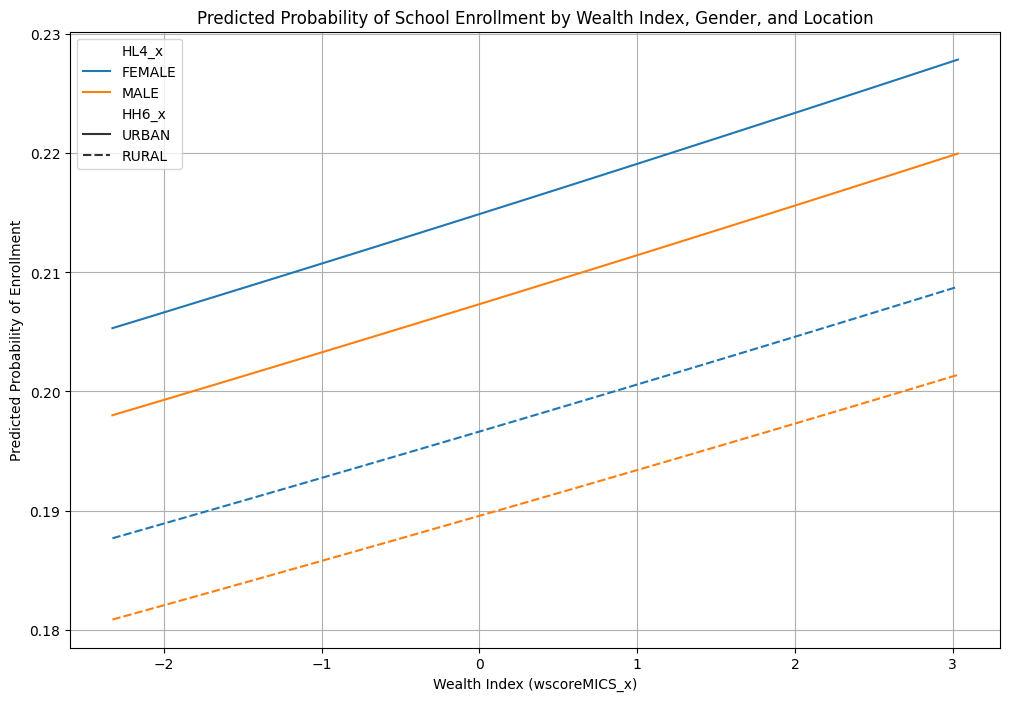

In [ ]:
# Visualize logistic regression predicted probabilities
# We can plot the predicted probabilities against one of the continuous variables
# while holding others constant at their means or specific values.
# Since 'wscoreMICS_x' is a continuous variable, let's plot predicted probabilities against it,
# for different genders and urban/rural locations.

# Create a new dataframe for prediction
# We'll create a range of wealth index values and combine them with gender and urban/rural categories
wealth_range = np.linspace(cleaned_df['wscoreMICS_x'].min(), cleaned_df['wscoreMICS_x'].max(), 100)
gender_categories = cleaned_df['HL4_x'].unique()
urban_rural_categories = cleaned_df['HH6_x'].unique()

# Create a grid of values for prediction
# The total number of rows will be the product of the number of values in each variable
n_wealth = len(wealth_range)
n_gender = len(gender_categories)
n_urban_rural = len(urban_rural_categories)

pred_data = pd.DataFrame({
    'wscoreMICS_x': np.tile(wealth_range, n_gender * n_urban_rural),
    'HL4_x': np.repeat(gender_categories, n_wealth * n_urban_rural),
    'HH6_x': np.tile(np.repeat(urban_rural_categories, n_wealth), n_gender)
})


# Predict the probabilities
pred_data['predicted_prob'] = model.predict(pred_data)

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=pred_data, x='wscoreMICS_x', y='predicted_prob', hue='HL4_x', style='HH6_x')
plt.title('Predicted Probability of School Enrollment by Wealth Index, Gender, and Location')
plt.xlabel('Wealth Index (wscoreMICS_x)')
plt.ylabel('Predicted Probability of Enrollment')
plt.grid(True)
plt.show()

## Conclusions

### Descriptive Statistics:

- We observed the overall enrollment rate and the distribution across different enrollment statuses.
- We calculated and visualized the enrollment rates by gender, showing a slight difference in enrollment patterns between males and females.
- We calculated and visualized the enrollment rates by income quintile, indicating a clear trend of increasing enrollment with higher wealth index.

### Inferential Analysis (Logistic Regression):

- The logistic regression model examined the impact of wealth index, gender, and urban/rural location on the probability of school enrollment.
The odds ratios suggest that:
- A higher wealth index is associated with increased odds of school enrollment.
- There is a small, but not statistically significant difference in the odds of enrollment between males and females, after controlling for wealth index and urban/rural location.
- Being in an urban area is associated with increased odds of school enrollment compared to being in a rural area, after controlling for wealth index and gender.
- The predicted probabilities plot visually demonstrates how the probability of enrollment changes with the wealth index for different gender and location groups.

### Final Remark:

Based on this analysis, household income (as proxied by the wealth index) appears to be a stronger predictor of school enrollment among Nigerian children than gender, although urban/rural location also plays a significant role.